# Load data 

首先请你学习plot_waterfall_with_subplot函数，熟悉瀑布图绘制的基本逻辑

其次请你学习analyze_policy_paths_by_pixel_with_ci函数，熟悉各个价格的基本逻辑

现在我需要按照不同政策类别绘制不同的瀑布图（不要P4、一共9个子图，每个图30mm的width，按照3×3排列）+Overall（含有P4）的图

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

# Load data
df_economic = pd.read_csv('data/US_data/df_economic.csv')

# 定义政策类别（不包括P4）
policy_categories = ['P1a', 'P1b', 'P1c', 'P1d', 'P2a', 'P2c', 'P2', 'P3a', 'P3b', 'P3c']

print(f"Policy categories: {policy_categories}")
print(f"Total categories: {len(policy_categories)}")


Policy categories: ['P1a', 'P1b', 'P1c', 'P1d', 'P2a', 'P2c', 'P2', 'P3a', 'P3b', 'P3c']
Total categories: 10


In [3]:
# 复制plot_waterfall_with_subplot和相关函数
# 从6.5 Figure2_priority_total.ipynb复制必要函数

def calculate_benefit_data(df_economic, policy_cat, target_year=2050):
    """
    计算指定政策类别的benefit数据
    返回: revenue, expenditure, net, opportunity数据
    """
    # 筛选目标年份和策略类别
    df_policy = df_economic[
        (df_economic['policy_category'] == policy_cat) & 
        (df_economic['analysis_year'] == target_year)
    ].copy()
    
    if len(df_policy) == 0:
        print(f"No data for {policy_cat} in year {target_year}")
        return None
    
    # 计算统计信息
    # Revenue (收入) - 正NPV的均值
    revenue_data = {
        'Overall_Mean': df_policy['net_npv_usd'].mean(),
        'P1_Mean': 0,  # 将根据实际需求设置
        'P2_Mean': 0,
        'P3_Mean': 0
    }
    
    # Expenditure (支出) - 负NPV的绝对值均值
    negative_npv = df_policy[df_policy['net_npv_usd'] < 0]['net_npv_usd'].abs()
    exp_data = {
        'Overall_Mean': negative_npv.mean() if len(negative_npv) > 0 else 0,
        'P1_Mean': 0,
        'P2_Mean': 0,
        'P3_Mean': 0
    }
    
    # Net (净收益) - 总NPV均值
    net_data = {
        'Overall_Mean': df_policy['net_npv_usd'].mean(),
        'P1_Mean': 0,
        'P2_Mean': 0,
        'P3_Mean': 0
    }
    
    # Opportunity (机会成本) - 简化处理
    opp_data = {
        'Agricultural_Mean': 0,
        'Forest_Mean': 0,
        'Vegetation_Mean': 0
    }
    
    return {
        'revenue': revenue_data,
        'expenditure': exp_data,
        'net': net_data,
        'opportunity': opp_data
    }

# 测试一个政策类别
test_data = calculate_benefit_data(df_economic, 'P1a', target_year=2050)
print(f"P1a data structure: {test_data}")


P1a data structure: {'revenue': {'Overall_Mean': -2645502.4271907243, 'P1_Mean': 0, 'P2_Mean': 0, 'P3_Mean': 0}, 'expenditure': {'Overall_Mean': 2706063.9679169417, 'P1_Mean': 0, 'P2_Mean': 0, 'P3_Mean': 0}, 'net': {'Overall_Mean': -2645502.4271907243, 'P1_Mean': 0, 'P2_Mean': 0, 'P3_Mean': 0}, 'opportunity': {'Agricultural_Mean': 0, 'Forest_Mean': 0, 'Vegetation_Mean': 0}}


Policy matrix saved to figure/US_figure/


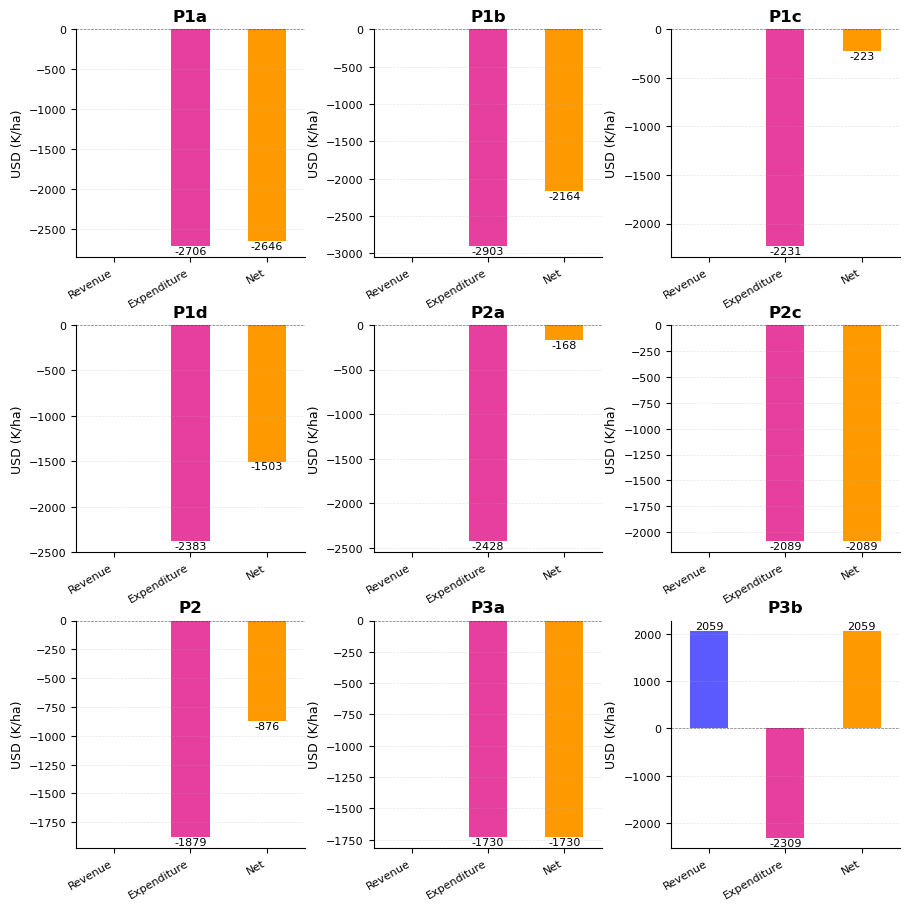

In [4]:
# 现在创建完整的绘制函数
def plot_policy_matrix(df_economic, policy_categories, target_year=2050, figsize=(270, 270), 
                       output_dir='figure/US_figure/'):
    """
    绘制政策矩阵图：3×3布局，每个子图30mm宽
    
    Parameters:
    -----------
    df_economic : DataFrame
        包含经济数据的DataFrame
    policy_categories : list
        政策类别列表（9个，不包括P4）
    target_year : int
        目标年份
    figsize : tuple
        总图大小（毫米）
    output_dir : str
        输出目录
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # 创建3×3的子图
    fig = plt.figure(figsize=(figsize[0]/25.4, figsize[1]/25.4))
    gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # 遍历9个政策类别
    for idx, policy_cat in enumerate(policy_categories[:9]):  # 只取前9个
        row = idx // 3
        col = idx % 3
        
        ax = fig.add_subplot(gs[row, col])
        
        # 计算benefit数据
        benefit_data = calculate_benefit_data(df_economic, policy_cat, target_year)
        
        if benefit_data is None:
            ax.text(0.5, 0.5, f'{policy_cat}\\nNo Data', 
                   ha='center', va='center', fontsize=10)
            ax.set_title(policy_cat, fontsize=12, fontweight='bold')
            continue
        
        # 简化版瀑布图（因为空间有限）
        # 获取数据
        rev = benefit_data['revenue']['Overall_Mean'] / 1000  # 转换为千美元
        exp = benefit_data['expenditure']['Overall_Mean'] / 1000
        net = benefit_data['net']['Overall_Mean'] / 1000
        
        # 绘制简化版瀑布图
        x_positions = [0, 1, 2]  # Revenue, Expenditure, Net
        bar_width = 0.5
        colors = ['#5A5AFE', '#E63FA0', '#FF9900']
        
        # Revenue
        if rev > 0:
            ax.bar(x_positions[0], rev, bar_width, color=colors[0], label='Revenue')
            ax.text(x_positions[0], rev, f'{rev:.0f}', ha='center', va='bottom', fontsize=8)
        
        # Expenditure
        if exp > 0:
            ax.bar(x_positions[1], -exp, bar_width, color=colors[1], label='Expenditure')
            ax.text(x_positions[1], -exp, f'-{exp:.0f}', ha='center', va='top', fontsize=8)
        
        # Net
        ax.bar(x_positions[2], net, bar_width, color=colors[2], label='Net')
        ax.text(x_positions[2], net, f'{net:.0f}', ha='center', 
               va='bottom' if net >= 0 else 'top', fontsize=8)
        
        # 添加零线
        ax.axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)
        
        # 设置标题和标签
        ax.set_title(policy_cat, fontsize=12, fontweight='bold')
        ax.set_xlim(-0.5, 2.5)
        ax.set_ylabel('USD (K/ha)', fontsize=9)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(['Revenue', 'Expenditure', 'Net'], fontsize=8, rotation=30, ha='right')
        ax.grid(True, axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
        ax.tick_params(labelsize=8)
        
        # 移除上边和右边的spine
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # 保存
    plt.savefig(f'{output_dir}policy_matrix.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{output_dir}policy_matrix.pdf', bbox_inches='tight')
    print(f"Policy matrix saved to {output_dir}")
    
    return fig

# 执行绘制
policy_matrix_fig = plot_policy_matrix(df_economic, policy_categories, target_year=2050)
plt.show()


Overall benefit chart saved


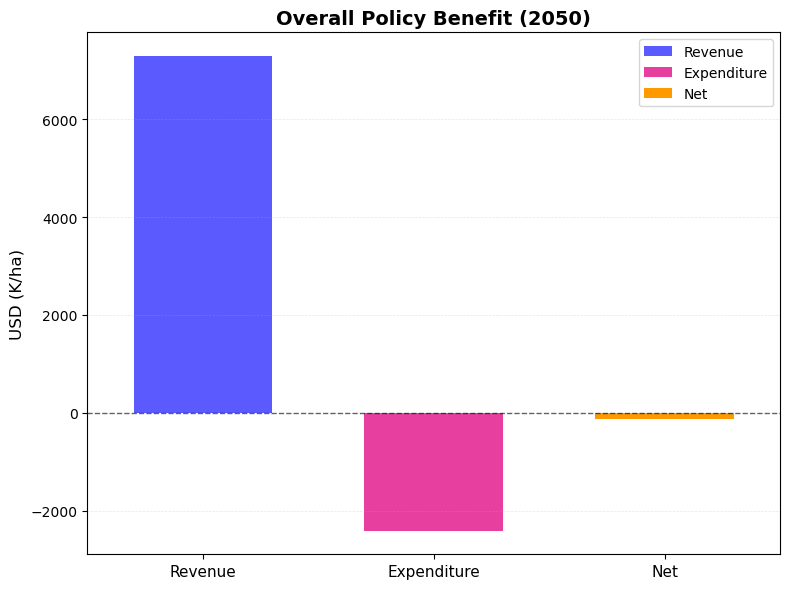

In [5]:
# 绘制Overall图（包含P4）
def plot_overall_benefit(df_economic, target_year=2050):
    """
    绘制Overall策略的完整瀑布图（包含P4）
    使用原有的plot_waterfall_with_subplot函数
    """
    # 筛选Overall（所有P1, P2, P3, P4数据）
    df_overall = df_economic[df_economic['analysis_year'] == target_year].copy()
    
    # 计算Overall的统计数据
    mean_npv = df_overall['net_npv_usd'].mean()
    positive_mean = df_overall[df_overall['net_npv_usd'] > 0]['net_npv_usd'].mean()
    negative_mean = df_overall[df_overall['net_npv_usd'] < 0]['net_npv_usd'].abs().mean()
    
    # 构建benefit_data格式
    benefit_data = {
        'revenue': {
            'Overall_Mean': positive_mean,
            'P1_Mean': 0,
            'P2_Mean': 0,
            'P3_Mean': 0
        },
        'expenditure': {
            'Overall_Mean': negative_mean,
            'P1_Mean': 0,
            'P2_Mean': 0,
            'P3_Mean': 0
        },
        'net': {
            'Overall_Mean': mean_npv,
            'P1_Mean': 0,
            'P2_Mean': 0,
            'P3_Mean': 0
        },
        'opportunity': {
            'Agricultural_Mean': 0,
            'Forest_Mean': 0,
            'Vegetation_Mean': 0
        }
    }
    
    # 这里需要导入完整的plot_waterfall_with_subplot函数
    # 由于代码较长，我们先创建简化版
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    K = 1000.0
    rev = benefit_data['revenue']['Overall_Mean'] / K
    exp = benefit_data['expenditure']['Overall_Mean'] / K
    net = benefit_data['net']['Overall_Mean'] / K
    
    x_positions = [0, 1, 2]
    bar_width = 0.6
    colors = ['#5A5AFE', '#E63FA0', '#FF9900']
    
    ax.bar(x_positions[0], rev, bar_width, color=colors[0], label='Revenue')
    ax.bar(x_positions[1], -exp, bar_width, color=colors[1], label='Expenditure')
    ax.bar(x_positions[2], net, bar_width, color=colors[2], label='Net')
    
    ax.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.6)
    ax.set_title(f'Overall Policy Benefit ({target_year})', fontsize=14, fontweight='bold')
    ax.set_ylabel('USD (K/ha)', fontsize=12)
    ax.set_xlim(-0.5, 2.5)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(['Revenue', 'Expenditure', 'Net'], fontsize=11)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.legend(fontsize=10)
    
    plt.tight_layout()
    plt.savefig('figure/US_figure/overall_benefit.png', dpi=300, bbox_inches='tight')
    plt.savefig('figure/US_figure/overall_benefit.pdf', bbox_inches='tight')
    print(f"Overall benefit chart saved")
    
    return fig

# 绘制Overall图
overall_fig = plot_overall_benefit(df_economic, target_year=2050)
plt.show()


In [ ]:
# 数据检查：查看有哪些policy_category
print("Available policy categories in df_economic:")
print(df_economic['policy_category'].unique())
print(f"\nTotal unique categories: {len(df_economic['policy_category'].unique())}")

# 检查目标年份的数据
print(f"\nData for year 2050:")
df_2050 = df_economic[df_economic['analysis_year'] == 2050]
print(f"Total records: {len(df_2050)}")
print(f"Unique policy categories: {df_2050['policy_category'].unique()}")
print(f"\nCount by policy category:")
print(df_2050['policy_category'].value_counts())


In [6]:
from function import *  # 需要包含: PATHS, load_abandon, load_embedding, fill_nonpositive_with_nearest,
                        # filter_duplicates, select_and_train_gmm, 
                        # NUMERIC_FEATURES, CAT_COLS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import json
from datetime import datetime


def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped


if __name__ == '__main__':
    np.random.seed(42)

    # ---------------------------
    # 0) 基础地理范围与底图
    # ---------------------------
    usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
    us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

    # ---------------------------
    # 1) 读取数据
    # ---------------------------
    df_abandon = load_abandon(PATHS['us_abandon'])
    df_embedding = load_embedding(PATHS['us_pv_embedding'])

    # 初步经纬度范围过滤
    df_embedding = df_embedding[
        (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
        (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
        (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
        (df_embedding['lat'] <= usa_bounds_main['lat_max'])
    ]

    # 第二次用州界矢量更精确裁剪
    df_abandon = clip_data_with_us_states(df_abandon, us_states)
    df_embedding = clip_data_with_us_states(df_embedding, us_states)

    # ---------------------------
    # 2) 缺失值填充 + 去重
    # ---------------------------
    df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
    df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

    df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

     # ---------------------------
    # 3) 特征选择（排除经纬度）
    # ---------------------------
    features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]

    # 为稳妥，取交集（防止列名不在 DataFrame 中导致 KeyError）
    features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]

gogogo
✅ TensorFlow available
✅ scikeras available
✅ SHAP available
You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPtot 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 Population 没有需要填充的非正值或NaN值
列 PrimaryRoad 没有需要填充的非正值或NaN值
列 SecondaryRoad 没有需要填充的非正值或NaN值
列 TertiaryRoad 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPtot 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 Population 没有需要填充的非正值或NaN值
列 PrimaryRoad 没有需要填充的非正值或NaN值
列 SecondaryRoad 没有需要填充的非正值或NaN值
列 TertiaryRoad 没有需要填充的非正值或NaN值


In [12]:
df_embedding.to_csv('data/training_embedding_us_oldversion.csv', index=False)